# Generate a simulation of a SED including atmsopheric effect and detector effect


- Author : Sylvie Dagoret-Campagne
- Date of creation :  July 4th 2016


- Original SED can be found here :

ftp://ftp.stsci.edu/cdbs/current_calspec/



In [54]:
import numpy as np

%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd


In [55]:
from astropy.io import fits

In [56]:
import os

In [57]:
from scipy.interpolate import UnivariateSpline

In [58]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## Calspec SED

In [59]:
path_sed='calspec'
basefile_sed='hd158485_stis_003.fits'
obj_name='hd158485'
airmass='1.1'
night_name='20160510'

In [60]:
file_sed=os.path.join(path_sed,basefile_sed)

In [61]:
hdulist=fits.open(file_sed)
#hdulist.info()

In [62]:
table_data=hdulist[1].data

In [63]:
wavelength_sed=(table_data.field('WAVELENGTH'))/10.   # convert the wavelength into nm
flux_sed=table_data.field('FLUX')

In [64]:
selected_indexes=np.where(np.logical_and(wavelength_sed>=0, wavelength_sed<1000.))

In [65]:
wavelength_sed=wavelength_sed[selected_indexes]
flux_sed=flux_sed[selected_indexes]

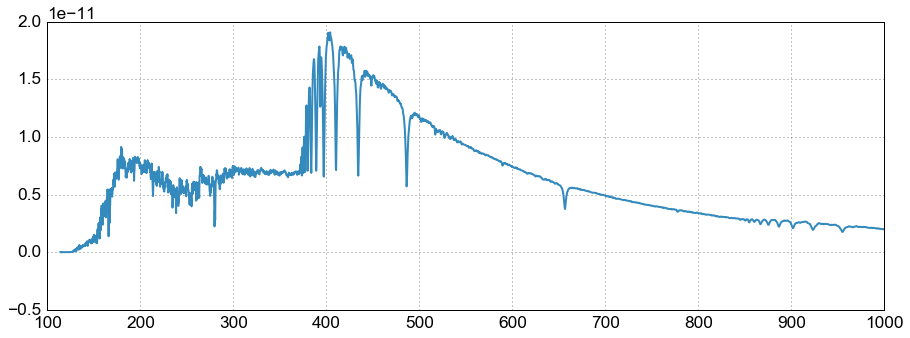

In [66]:
plt.plot(wavelength_sed,flux_sed,linewidth=2)
#plt.xlim(0.,1000.)

## CCD

In [67]:
path_ccd='detectoreffect'
basefile_ccd='transmissions-LSST.dat'

In [68]:
file_ccd=os.path.join(path_ccd,basefile_ccd)

In [69]:
df=pd.read_csv(file_ccd,names=['wl','Topt','Tccd','U','G','R','I','Z','Y4','atm'],sep='\t')

In [70]:
wavelength_ccd=df['wl']
efficiency_ccd=df['Tccd']/100.
transmission_opt=df['Topt']/100.

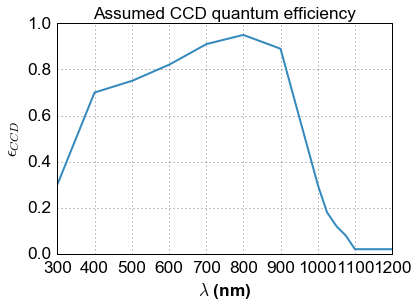

In [71]:
figname='ccd.pdf'
plt.figure(figsize=(6.,4.))
plt.plot(wavelength_ccd,efficiency_ccd,linewidth=2)
plt.title('Assumed CCD quantum efficiency')
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('$\epsilon_{CCD}$')
plt.savefig(figname)

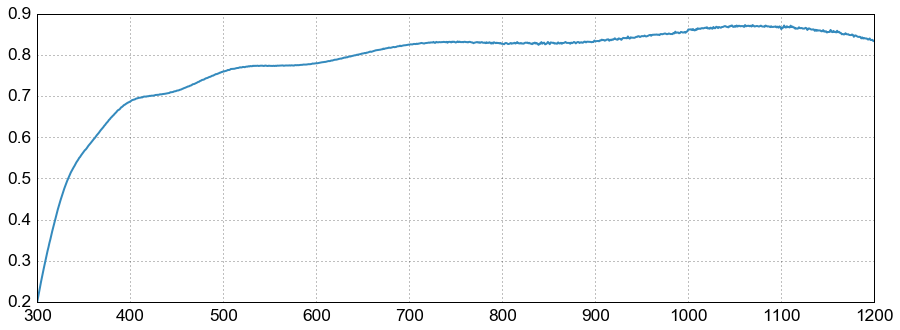

In [72]:
plt.plot(wavelength_ccd,transmission_opt,linewidth=2)

### fonction to get the CCT efficiency at anly wavelenth

- Interpolation

In [73]:
wavelength_to_TCCD_spl=UnivariateSpline(wavelength_ccd,efficiency_ccd)

## TOps

## Atmosphere

In [74]:
index=107 # z=1.1

In [75]:
path_atm='libradtran/monocam_2016-05-11/afglus'
root_file='UVSPEC_REPTRAN_SOLAR_ALT22_COARSE_'
ext_file='.out'

In [76]:
basefile_atm=root_file+str(index)+ext_file

In [77]:
file_atm=os.path.join(path_atm,basefile_atm)

In [78]:
atm_array=np.loadtxt(file_atm)
wavelength_atm=atm_array[:,0] # in nm
transmission_atm=atm_array[:,1]

In [79]:
selected_indexes=np.where(np.logical_and(wavelength_atm>=0, wavelength_atm<1000.))

In [80]:
wavelength_atm=wavelength_atm[selected_indexes]
transmission_atm=transmission_atm[selected_indexes]

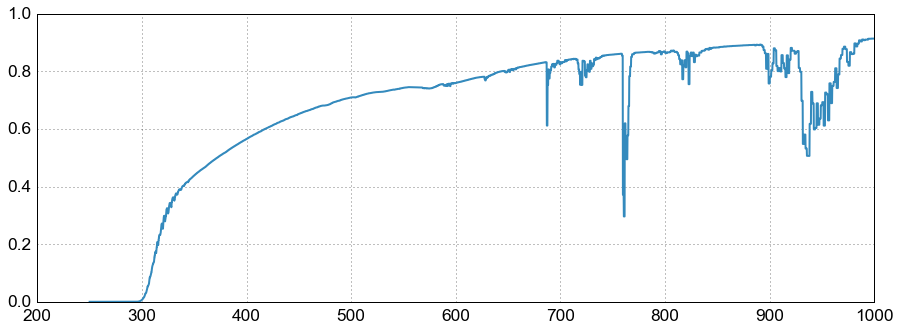

In [81]:
plt.plot(wavelength_atm,transmission_atm,linewidth=2)

### Interpolation

In [82]:
wavelength_to_TATM_spl=UnivariateSpline(wavelength_atm,transmission_atm)

## Compute transmissions

In [83]:
wavelength_sed.shape

(3729,)

In [84]:
wavelength_atm.shape

(7500,)

In [85]:
wavelength_ccd.shape

(901,)

In [86]:
#TCCD=wavelength_to_TCCD_spl(wavelength_sed)
TCCD=np.interp(wavelength_sed,wavelength_ccd,efficiency_ccd)

In [87]:
TOPT=np.interp(wavelength_sed,wavelength_ccd,transmission_opt)

In [88]:
#TATM=wavelength_to_TATM_spl(wavelength_sed)
TATM=np.interp(wavelength_sed,wavelength_atm,transmission_atm)

(0.0, 1.0)

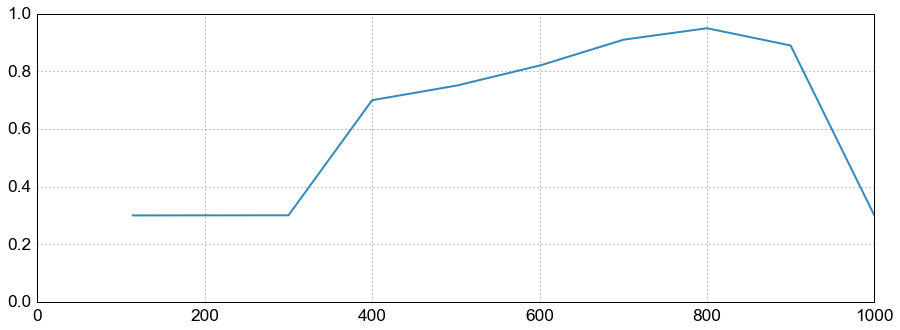

In [89]:
plt.plot(wavelength_sed,TCCD,linewidth=2)
plt.xlim(0.,1000.)
plt.ylim(0.,1.)

(0.0, 1000.0)

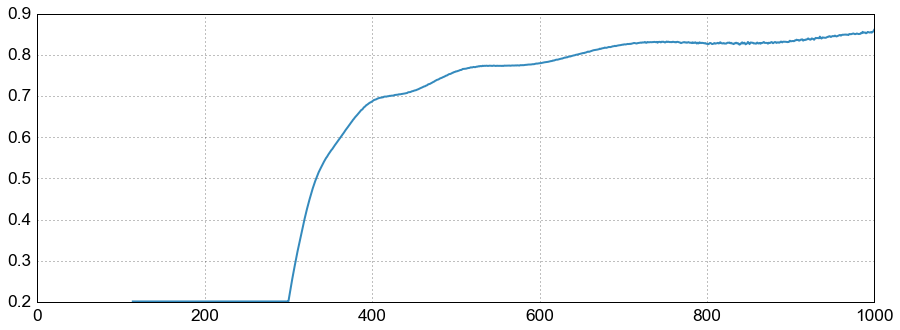

In [90]:
plt.plot(wavelength_sed,TOPT,linewidth=2)
plt.xlim(0.,1000.)
#plt.ylim(0.,1.)

(0.0, 1.0)

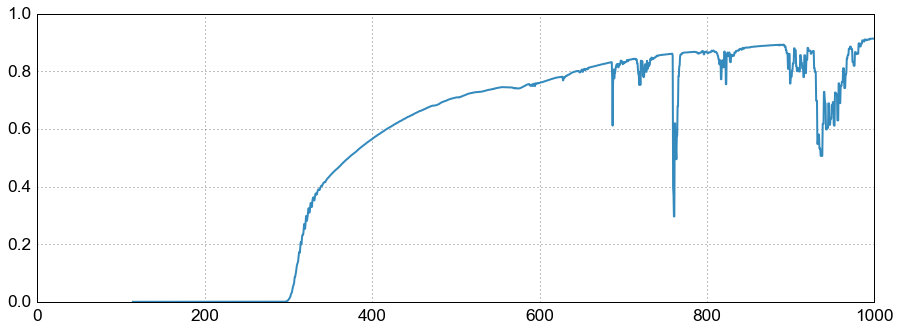

In [91]:
plt.plot(wavelength_sed,TATM,linewidth=2)
plt.xlim(0.,1000.)
plt.ylim(0.,1.)

In [92]:
SED1=flux_sed
SED2=flux_sed*TCCD
SED3=flux_sed*TCCD*TATM
SED4=flux_sed*TCCD*TATM*TOPT

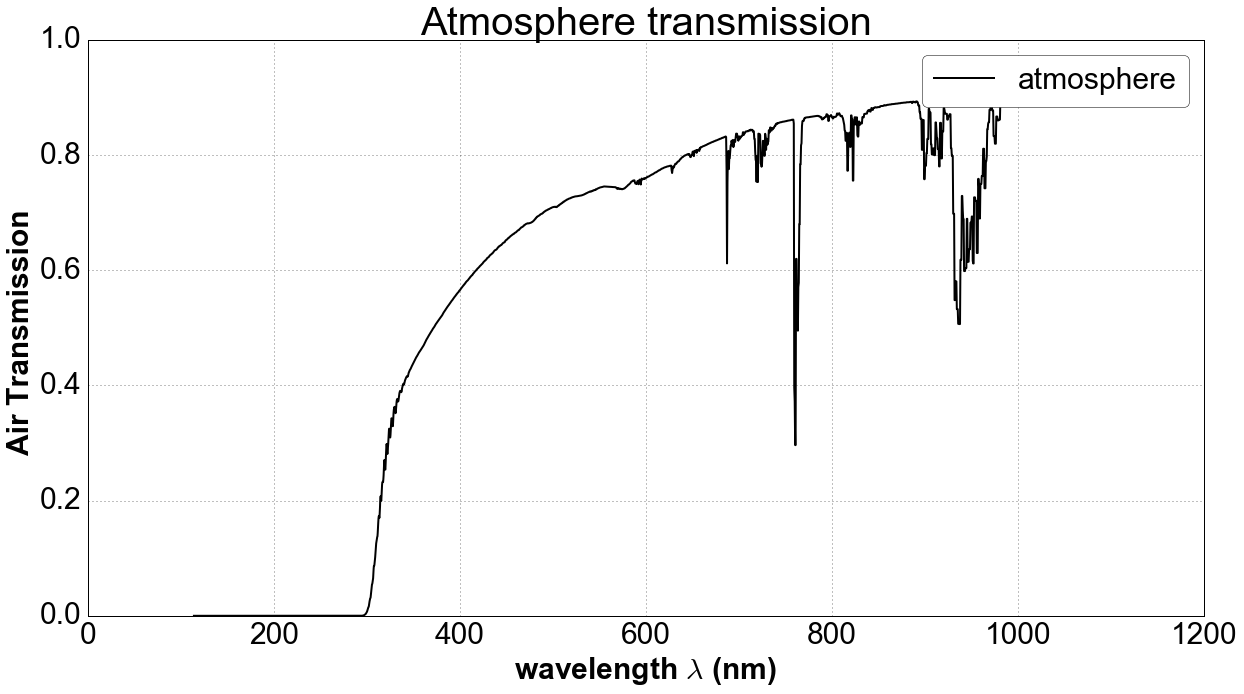

In [93]:
plt.figure(figsize=(20,10))
plt.plot(wavelength_sed,TATM,label='atmosphere',color='k',linewidth=2)
plt.xlim(0,1200.)
plt.ylim(0,1.)
plt.title('Atmosphere transmission',fontsize=40)
plt.xlabel('wavelength $\lambda$ (nm)',fontsize=30)
plt.ylabel('Air Transmission ',fontsize=30)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.legend(fontsize=30)
plt.show()

## Plot the three SED

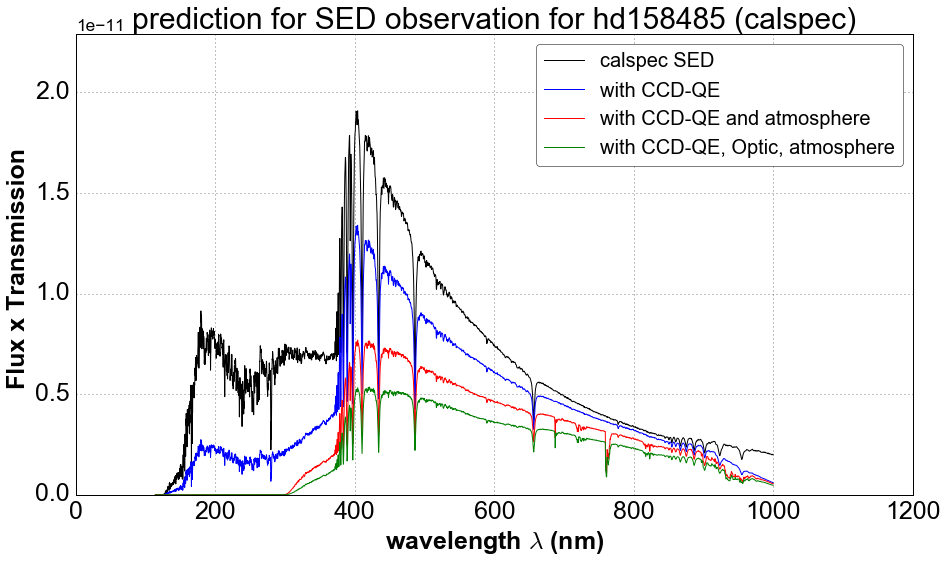

In [94]:
plt.figure(figsize=(15,8))
plt.plot(wavelength_sed,SED1,label='calspec SED',color='k')
plt.plot(wavelength_sed,SED2,label='with CCD-QE',color='b')
plt.plot(wavelength_sed,SED3,label='with CCD-QE and atmosphere',color='r')
plt.plot(wavelength_sed,SED4,label='with CCD-QE, Optic, atmosphere',color='g')
plt.xlim(0,1200.)
plt.ylim(0,SED1.max()*1.2)
plt.title('prediction for SED observation for hd158485 (calspec)',fontsize=30)
plt.xlabel('wavelength $\lambda$ (nm)',fontsize=25)
plt.ylabel('Flux x Transmission ',fontsize=25)
plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
plt.legend(fontsize=20)
plt.show()


In [95]:
SED1_2=flux_sed*(wavelength_sed/900.)
SED2_2=flux_sed*TCCD*(wavelength_sed/900.)
SED3_2=flux_sed*TCCD*TATM*(wavelength_sed/900.)
SED4_2=flux_sed*TCCD*TATM*TOPT*(wavelength_sed/900.)

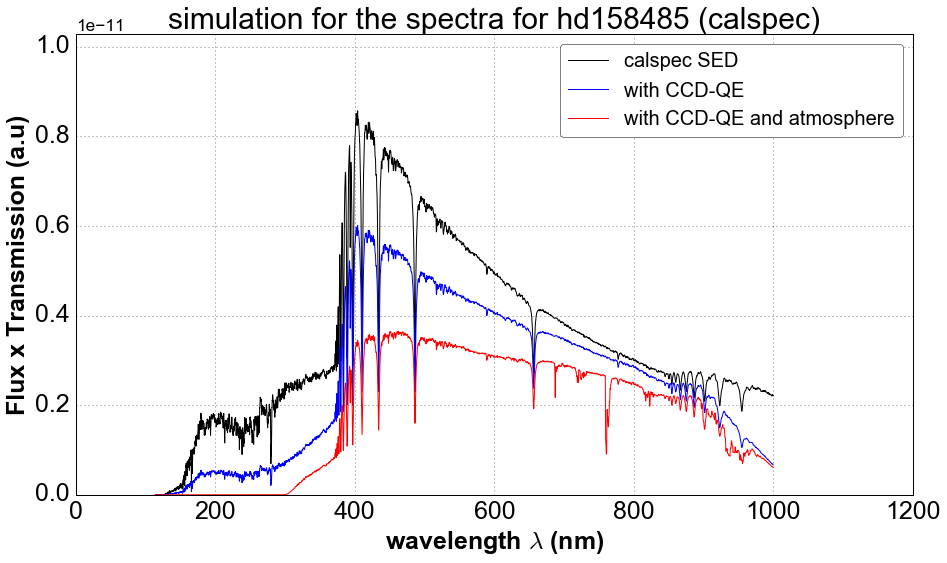

In [96]:
figname='sed_hd158485.pdf'
plt.figure(figsize=(15,8))
plt.plot(wavelength_sed,SED1_2,label='calspec SED',color='k')
plt.plot(wavelength_sed,SED2_2,label='with CCD-QE',color='b')
plt.plot(wavelength_sed,SED3_2,label='with CCD-QE and atmosphere',color='r')
#plt.plot(wavelength_sed,SED4_2,label='with CCD-QE, Optic, atmosphere',color='g')
plt.xlim(0,1200.)
plt.ylim(0,SED1_2.max()*1.2)
plt.title('simulation for the spectra for hd158485 (calspec)',fontsize=30)
plt.xlabel('wavelength $\lambda$ (nm)',fontsize=25)
plt.ylabel('Flux x Transmission (a.u)',fontsize=25)
plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
plt.legend(loc='best',fontsize=20)
plt.savefig(figname)
plt.show()

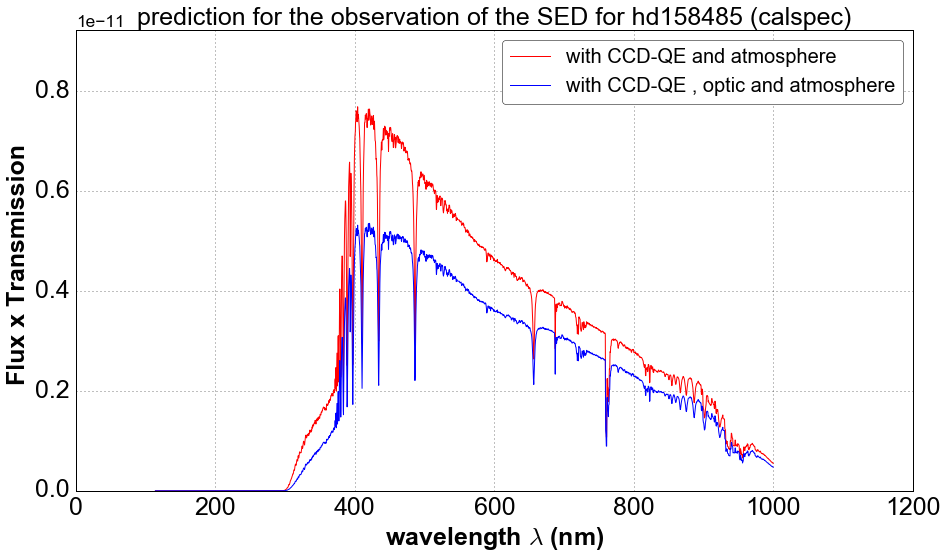

In [97]:
plt.figure(figsize=(15,8))
plt.plot(wavelength_sed,SED3,label='with CCD-QE and atmosphere',color='r')
plt.plot(wavelength_sed,SED4,label='with CCD-QE , optic and atmosphere',color='b')
plt.xlim(0,1200.)
plt.ylim(0,SED3.max()*1.2)
plt.title('prediction for the observation of the SED for hd158485 (calspec)',fontsize=25)
plt.xlabel('wavelength $\lambda$ (nm)',fontsize=25)
plt.ylabel('Flux x Transmission ',fontsize=25)
plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
plt.legend(loc='best',fontsize=20)
plt.show()

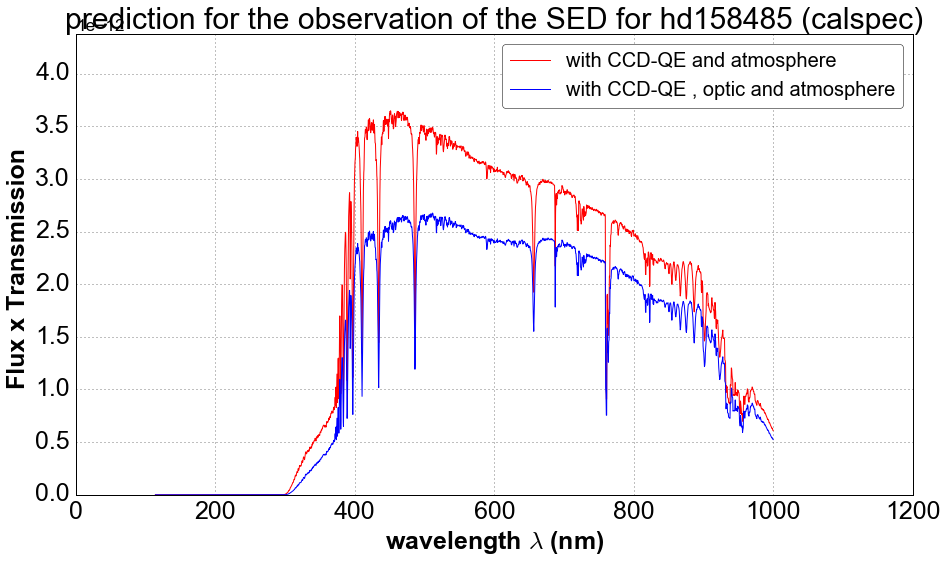

In [98]:
plt.figure(figsize=(15,8))
plt.plot(wavelength_sed,SED3_2,label='with CCD-QE and atmosphere',color='r')
plt.plot(wavelength_sed,SED4_2,label='with CCD-QE , optic and atmosphere',color='b')
plt.xlim(0,1200.)
plt.ylim(0,SED3_2.max()*1.2)
plt.title('prediction for the observation of the SED for hd158485 (calspec)',fontsize=30)
plt.xlabel('wavelength $\lambda$ (nm)',fontsize=25)
plt.ylabel('Flux x Transmission ',fontsize=25)
plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
plt.legend(loc='best',fontsize=20)
plt.show()

## Save spectra in a fits file

In [99]:
tablefitsfile='SEDPred_'+obj_name+'_'+night_name+'_'+str(index)+'.fits'
print(tablefitsfile)

SEDPred_hd158485_20160510_107.fits


In [100]:
prim_hdr=fits.Header()
prim_hdr['OBJ_NAME']=obj_name
prim_hdr['AIRMASS']=airmass
prim_hdr['UNITS']='wavelength in nm'
prim_hdr['COMMENT']="Prediction of observable SED"
primhdu=fits.PrimaryHDU(header=prim_hdr)

In [101]:
col1 = fits.Column(name='WAVELENGTH', format='E', array=wavelength_sed)
col2 = fits.Column(name='SEDcalspec', format='E', array=SED1)
col3 = fits.Column(name='SEDxQE', format='E', array=SED2)
col4 = fits.Column(name='SEDxQExATM', format='E', array=SED3)
col5 = fits.Column(name='SEDxQExATMxTopt', format='E', array=SED4)

In [102]:
cols = fits.ColDefs([col1, col2,col3,col4,col5])     # definition of the columns

In [103]:
#tbhdu = fits.BinTableHDU.from_columns(cols)     # new binary table HDU

In [104]:
#thdulist = fits.HDUList([primhdu, tbhdu])

In [105]:
#thdulist.writeto(tablefitsfile,clobber=True)

In [106]:
# example to read a file

path_sed='.'
tablefitsfile_sed=tablefitsfile

# file of SED
fullfilename_sed=os.path.join(path_sed,tablefitsfile_sed)

# get the content of the file
hdulist=fits.open(fullfilename_sed)
hdulist.info()

table_data=hdulist[1].data
print table_data.columns  # shows the columns names of the table

    # retrieve the table inside SED file

wavelength_sed=table_data.field('WAVELENGTH')
flux_sed=table_data.field('SEDcalspec')
flux_sedccd=table_data.field('SEDxQE')
flux_sedccdatm=table_data.field('SEDxQExATM')
flux_sedccdatmopt=table_data.field('SEDxQExATMxTopt')


    # rename
SED1=flux_sed             # SED of the star
SED2=flux_sedccd          # SED of star multipled by CCD efficiency 
SED3=flux_sedccdatm       # SED of star multipled by CCD efficiency and atmosphere transparency
SED4=flux_sedccdatmopt    # SED of star multipled by CCD efficiency,atmosphere transparency,
                              # optic throuput


IOError: [Errno 2] No such file or directory: './SEDPred_hd158485_20160510_107.fits'